In [ ]:
import time
import os
import urllib.parse

import numpy as np
from tensorflow.core.example.example_pb2 import Example
from tensorflow.core.example.feature_pb2 import Feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap


# Get data
We are using the Census data. We are proposing a process to assess algorithmic bias in models, so instead of using the classification for whether people have >50k income, it will be used to classify if people should get a loan.

In [ ]:
df[label_column].value_counts().plot.barh()

In [ ]:
X = df.drop(label_column, axis=1)
y = df[label_column]

#### Data Analysis

In [ ]:
import math
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [ ]:
X_analysis = X_display.copy()
X_analysis = X_analysis.join(pred_df)

X_analysis.tail(5)

In [ ]:
X_display.gender.value_counts().plot.barh()

In [ ]:
flds = ["gender", "age", "education-num", "capital-gain", 
                  "capital-loss", "hours-per-week"]


enc_summ = X_display[flds].groupby("gender", as_index=False).mean()
enc_summ


# Census income classification with Keras

We use keras to perform this computation


In [1]:
from sklearn.model_selection import train_test_split
import sklearn
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sn
import numpy as np
import shap
shap.initjs()

Using TensorFlow backend.


In [141]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

X['Income'] = y
X.to_csv["data/adult_processed.csv", sep="\t"]

X_display['In']

input_features = ["age", "workclass", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]

categorical_features = ["workclass", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

X.columns = input_features
X_display.columns = input_features

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k,dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [60]:
# Defining model as functional type

input_els = []
encoded_els = []
for k,dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)

layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1, activation='sigmoid')(layer1)

# y_train_hot = keras.utils.to_categorical(y_train)
# y_valid_hot = keras.utils.to_categorical(y_valid)

# train model
model = Model(inputs=input_els, outputs=[out])
model.compile(optimizer="adam", loss='binary_crossentropy')
model.fit(
    [X_train[k].values for k,t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k,t in dtypes], y_valid)
)

Train on 26048 samples, validate on 6513 samples
Epoch 1/50
26048/26048 [==============================] - 1s 45us/step - loss: 0.6324 - val_loss: 0.4888
Epoch 2/50
26048/26048 [==============================] - 0s 10us/step - loss: 0.4603 - val_loss: 0.3945
Epoch 3/50
26048/26048 [==============================] - 0s 9us/step - loss: 0.3863 - val_loss: 0.3479
Epoch 4/50
26048/26048 [==============================] - 0s 10us/step - loss: 0.3568 - val_loss: 0.3336
Epoch 5/50
26048/26048 [==============================] - 0s 10us/step - loss: 0.3438 - val_loss: 0.3278
Epoch 6/50
26048/26048 [==============================] - 0s 10us/step - loss: 0.3363 - val_loss: 0.3243
Epoch 7/50
26048/26048 [==============================] - 0s 10us/step - loss: 0.3304 - val_loss: 0.3220
Epoch 8/50
26048/26048 [==============================] - 0s 9us/step - loss: 0.3280 - val_loss: 0.3204
Epoch 9/50
26048/26048 [==============================] - 0s 11us/step - loss: 0.3249 - val_loss: 0.3196
Epoch 10

In [61]:
input_test = [X.iloc[:,i] for i in range(X.shape[1])]
score = model.evaluate(input_test, y, verbose=1)
# print(list(predictions.T[0]))
# ??np.argmax
print(score)

32561/32561 [==============================] - 2s 69us/step
0.30577611468691396


In [62]:
input_test = [X_valid.iloc[:,i] for i in range(X.shape[1])]
probabilities = model.predict(input_test)
print(list(probabilities.T[0])[:10])
# print(list(predictions.T[1])[:10])

[0.07717203, 0.530101, 0.0290726, 0.01226429, 0.21036455, 0.14206398, 0.05968124, 0.41292122, 0.0005189884, 0.9747779]


In [63]:
pred = list((probabilities >= 0.5).astype(int).T[0])
print(pred[:10])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


In [64]:
print(sklearn.metrics.classification_report(y_valid, pred))

print("\nF1 Score:", sklearn.metrics.f1_score(y_valid, pred))

print("\nAccuracy:", sklearn.metrics.accuracy_score(y_valid, pred))

              precision    recall  f1-score   support

       False       0.89      0.93      0.91      4951
        True       0.74      0.62      0.67      1562

   micro avg       0.86      0.86      0.86      6513
   macro avg       0.81      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513


F1 Score: 0.674757281553398

Accuracy: 0.855980346998311


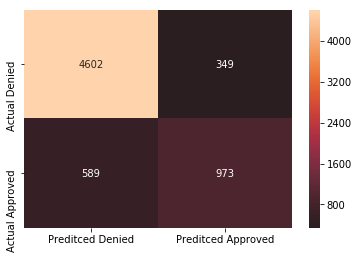

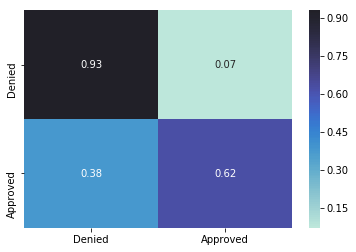

In [65]:

confusion = sklearn.metrics.confusion_matrix(
    y_valid,
    pred)


confusion_df = pd.DataFrame(confusion,
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

confusion_scaled = \
    confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]

confusion_scaled_df = pd.DataFrame(confusion_scaled, 
            index=["Denied", "Approved"], 
            columns=["Denied", "Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)
plt.show()

sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)
plt.show()

0.7762142621247766


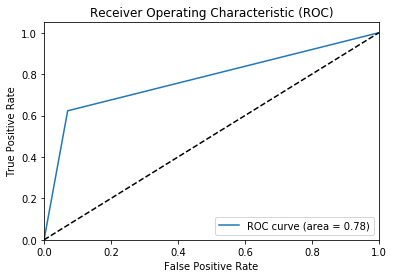

In [66]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
        y_valid, pred)

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [67]:
def shap_predict(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values

shap_explainer = shap.KernelExplainer(shap_predict, X.iloc[:100,:])

In [68]:
shap_idx = 9
shap_x = X.iloc[shap_idx,:]
shap_display_x = X_display.iloc[shap_idx,:]
shap_values = shap_explainer.shap_values(shap_x, nsamples=500)

In [135]:
print("Probability: ", probabilities[shap_idx])
shap.force_plot(shap_explainer.expected_value, shap_values, shap_display_x)

Probability:  [0.9747779]


In [70]:
shap_idx_multi_from = 15
shap_idx_multi_to = 40

In [72]:
shap_x_multi = X.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_display_multi = X_display.iloc[shap_idx_multi_from:shap_idx_multi_to,:]
shap_y_multi = y[shap_idx_multi_from:shap_idx_multi_to]

In [73]:
shap_values_multi = shap_explainer.shap_values(shap_x_multi, nsamples=500)

100%|██████████| 25/25 [01:20<00:00,  3.23s/it]


In [74]:
shap.force_plot(shap_explainer.expected_value, shap_values_multi, shap_display_multi)


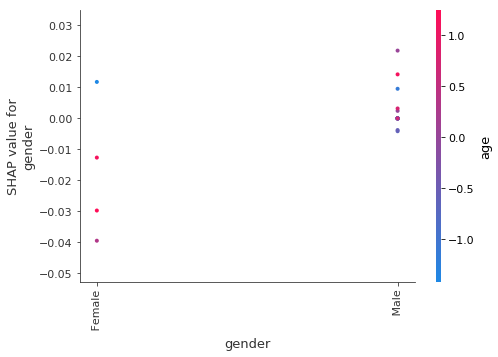

In [75]:
shap.dependence_plot("gender", 
                     shap_values_multi, 
                     shap_x_multi, 
                     display_features=shap_display_multi)

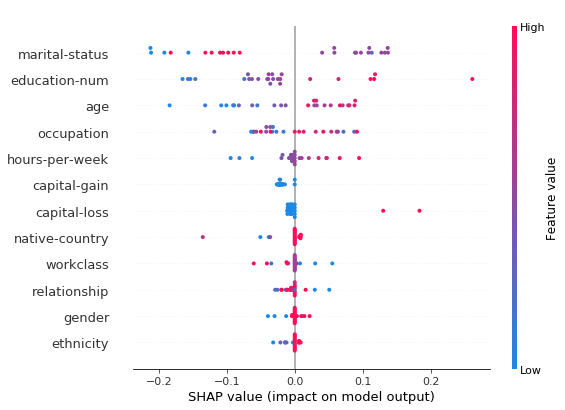

In [76]:
shap.summary_plot(shap_values_multi, shap_x_multi)

# LIME on Keras+Tensorflow

In [139]:
from lime.lime_tabular import LimeTabularExplainer

In [142]:
tf_lime_explainer = LimeTabularExplainer(
                X_train.values,
                class_names=["No", "Yes"],
                feature_names=list(X_train.columns),
                categorical_features=categorical_features)

In [148]:
def lime_predict_proba(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    prob_pairs = np.array([1-values, values]).T
    return prob_pairs

tf_lime_explanation = tf_lime_explainer.explain_instance(
        X_train.iloc[0,:], lime_predict_proba, num_features=13) 

/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.685877e-30
  overwrite_a=True).T


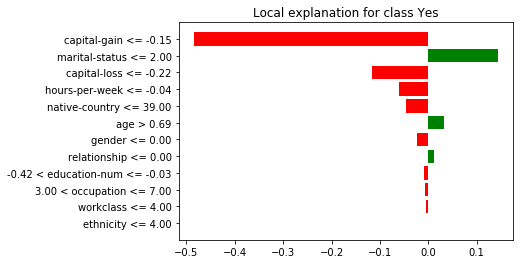

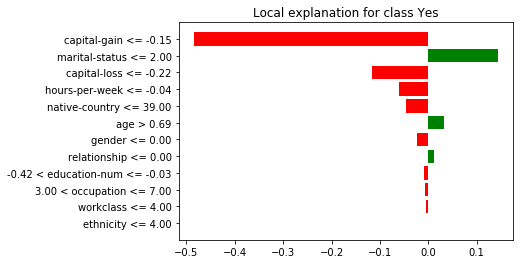

In [149]:
tf_lime_explanation.as_pyplot_figure()

In [150]:
tf_lime_explanation.show_in_notebook(show_table=True, show_all=True)

# Experiments

In [ ]:
import sklearn
import shap

X,y = shap.datasets.adult()

In [ ]:
X_train, X_valid, y_train, y_valid = 
    sklearn.model_selection.train_test_split(
        X, y, test_size=0.2, random_state=7)


In [ ]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

In [ ]:
predictions = knn.predict(X_valid)

In [ ]:
print(classification_report(y_valid, predictions))

In [ ]:
import pandas as pd
import numpy as np
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns

In [ ]:

# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skiprows=[0], skipinitialspace=True)

df["loan"] = df["loan"].apply(lambda x: ">50K" if x in [">50K", ">50K."] else "<=50K").astype(str)

df.loan.value_counts().plot.barh()

In [ ]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_data.drop("loan", axis=1), encoded_data["loan"], train_size=0.70)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")), 
                       columns=X_train.columns)

X_test = scaler.transform(X_test.astype("float64"))

In [ ]:
import math
encoded_data, encoders = number_encode_features(df)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [ ]:
print(encoders)

In [ ]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=encoders["loan"].classes_, 
            yticklabels=encoders["loan"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
        y_test, y_pred)

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
## Define path data
COLUMNS = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital',
           'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
           'hours_week', 'native_country', 'label']
PATH = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
PATH_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

df_train = pd.read_csv(PATH, skipinitialspace=True, names = COLUMNS, index_col=False)
df_test = pd.read_csv(PATH_test,skiprows = 1, skipinitialspace=True, names = COLUMNS, index_col=False)

label = {'<=50K': 0,'>50K': 1}
df_train.label = [label[item] for item in df_train.label]
label_t = {'<=50K.': 0,'>50K.': 1}
df_test.label = [label_t[item] for item in df_test.label]


## Add features to the bucket: 
### Define continuous list
CONTI_FEATURES  = ['age', 'fnlwgt','capital_gain', 'education_num', 'capital_loss', 'hours_week']
### Define the categorical list
CATE_FEATURES = ['workclass', 'education', 'marital', 'occupation', 'relationship', 'race', 'sex', 'native_country']

continuous_features = [tf.feature_column.numeric_column(k) for k in CONTI_FEATURES]		

relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    'relationship', [
        'Husband', 'Not-in-family', 'Wife', 'Own-child', 'Unmarried',
        'Other-relative'])

categorical_features = [tf.feature_column.categorical_column_with_hash_bucket(k, hash_bucket_size=1000) for k in CATE_FEATURES]

model = tf.estimator.LinearClassifier(
    n_classes = 2,
    model_dir="ongoing/train", 
    feature_columns=categorical_features+ continuous_features)

FEATURES = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_week', 'native_country']
LABEL= 'label'
def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle=True):
    return tf.estimator.inputs.pandas_input_fn(
       x=pd.DataFrame({k: data_set[k].values for k in FEATURES}),
       y = pd.Series(data_set[LABEL].values),
       batch_size=n_batch,   
       num_epochs=num_epochs,
       shuffle=shuffle)

model.train(input_fn=get_input_fn(df_train, 
                                      num_epochs=None,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)


In [ ]:
model.evaluate(input_fn=get_input_fn(df_test, 
                                      num_epochs=1,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)

In [ ]:
def square_var(df_t, df_te, var_name = 'age'):
    df_t['new'] = df_t[var_name].pow(2) 
    df_te['new'] = df_te[var_name].pow(2) 
    return df_t, df_te

df_train_new, df_test_new = square_var(df_train, df_test, var_name = 'age')

CONTI_FEATURES_NEW  = ['age', 'fnlwgt','capital_gain', 'education_num', 'capital_loss', 'hours_week', 'new']
continuous_features_new = [tf.feature_column.numeric_column(k) for k in CONTI_FEATURES_NEW]
print(continuous_features_new)

model_1 = tf.estimator.LinearClassifier(
    model_dir="ongoing/train1", 
    feature_columns=categorical_features+continuous_features_new)


model_1.train(input_fn=get_input_fn(df_train, 
                                      num_epochs=None,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)